# Machine Learning in Python

- Tools: scikit-learn (`sklearn`)
    - Data Partitioning
    - Feature selection
    - Modeling: SVM
    - Model Assessment


For more reading on scikit-learn (`sklearn`) and machine learning in Python: https://scikit-learn.org/stable/index.html

# Machine Learning: General Steps

1. Data Partitioning
2. Feature Selection
3. Model
4. Model Assessment

## Setup

In [1]:
# import ds/plotting packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Import nltk package 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# import random for randomizing
import random

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# scikit-learn imports
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Uncomment if you need to download the NLTK English tokenizer and the stopwords of all languages
# nltk.download('punkt')
# nltk.download('stopwords')

# Example: Class Responses

## Data

Student responses on COGS 108 Mid-course survey to the following two questions: 

- What have you enjoyed MOST about COGS 108 so far? Please explain.
- What have you enjoyed LEAST about COGS 108 so far? Please explain.

In [3]:
# read data in
# 1 = most; 0 = least
df = pd.read_csv('https://raw.githubusercontent.com/shanellis/datasets/master/COGS108_ml.csv', encoding="ISO-8859-1")
df.tail()

,response,most_least,quarter
3454,I can't say that there's bad about this course.,0,sp21
3455,"Aside from the lecture time, which can't be he...",0,sp21
3456,"I don't think this is really an issue at all, ...",0,sp21
3457,Nothing in particular,0,sp21
3458,It has been hard making it to lectures in the ...,0,sp21


In [4]:
# randomly sort data frame
df = df.sample(frac=1, random_state=200).reset_index(drop=True)
df.head()

,response,most_least,quarter
0,I don't understand some basic aspects of pushi...,0,fa20
1,Working with my group has been a little frustr...,0,wi21
2,The consistent amount of assignments,0,wi21
3,The lectures are honestly super interesting an...,1,sp19
4,Self-paced lectures,1,fa20


Randomly sorted data frame:
- for selection of training and test set
- will be approximately balanced between outcomes in each

In [5]:
# see how much data we're working with
df.shape

(3459, 3)

In [13]:
df.groupby('quarter')['response'].count()

quarter
fa20    551
sp19    631
sp20    705
sp21    466
wi20    491
wi21    615
Name: response, dtype: int64

In [16]:
705/3459

0.20381613183000868

### Train,  Validate, Test

- Training set is what we use for creating the model
- Validation set is what we use for fine tuning the model -- checking which hyper-parameters are best
- Test set is what we use to figure out how good the model will do next year with new data arriving

#### Method (1) - Manual split, split by quarter

- We'll test the model on one quarter's responses
- We'll validate the model on another quarter's responses
- We'll train the model on everything else



In [20]:


## Validation
df_validation = df[df['quarter']=='sp20']
              
## Test
df_test = df[df['quarter']=='sp19']

## Train
df_train = df[~df['quarter'].isin(['sp19','sp20'])]


In [21]:
print(df_train.shape, df_validation.shape, df_test.shape)

(2123, 3) (705, 3) (631, 3)


#### Clicker Question #1

How well do you think we will be able to predict whether a student comment is a response to what they liked most vs what they liked least in our ***training*** dataset?

- A) Accuracy ~0%
- B) Accuracy ~25%
- C) Accuracy ~50%
- D) Accuracy ~75%
- E) Accuracy ~100%

#### Clicker Question #2

How well do you think we will be able to predict whether a student comment is a response to what they liked most vs what they liked least in our ***validation*** dataset?

- A) Accuracy ~0%
- B) Accuracy ~25%
- C) Accuracy ~50%
- D) Accuracy ~75%
- E) Accuracy ~100%

#### Thinking this through

Is this a good idea to split up by quarter?  What could happen here?

#### Method (2) - sklearn split, randomize the data
- Training set 60% of the data randomly mixed across quarters
- Validation set 20% of the data randomly mixed across quarters
- Test set 20% of the data randomly mixed across quarters

In [28]:
from sklearn.model_selection import train_test_split

X_trainvalid, X_test, Y_trainvalid, Y_test = train_test_split(
    df['response'], df['most_least'], test_size=0.2, random_state=42)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_trainvalid, Y_trainvalid, test_size=0.25

)

print(X_train.shape, X_valid.shape, X_test.shape)

(2075,) (692,) (692,)


## Prediction Task: 

**Classify text from students as 'most liked' or 'least liked'**

#### 11 Steps to Prediction:

1. Specify parameters for TF-IDF calculation
2. Calculate TF-IDF from text input (predictors)
3. Extract most or least (outcome)
4. Specify how data will be partitioned
5. Partition the data
6. Train model
7. Predict in training
8. Predict in testing
9. Assess accuracy in training
10. Assess accuracy in test set
11. IF NEEDED: Model selection + test process that replaces steps 6-10 

### Data Processing

Step 1: Determine how you'll convert a collection of raw documents to a matrix of TF-IDF features.

In [29]:
# Create vectorizer & specify parameters
tfidf = TfidfVectorizer(sublinear_tf=True, #apply sublinear TF scaling
                        analyzer='word',   #specify tokenizer
                        max_features=500, # specify max # of features to include
                        tokenizer=word_tokenize)

* sublinear TF scaling - replaces term frequency (TF) with $1 + log(TF)$

Step 2: Generate matrix of TF-IDF features.

In [30]:
# Learn vocabulary and idf, return term-document matrix.
# return an array;our predictor
tfidf_X = tfidf.fit_transform(X_train).toarray()

# take a look at the output
print(tfidf_X.shape)

print("min: " , np.min(tfidf_X), '\n',
      "mean: ", np.mean(tfidf_X), '\n',
      "max: ",  np.max(tfidf_X))

(2075, 500)
min:  0.0 
 mean:  0.00691392746045586 
 max:  1.0


In [31]:
tfidf_X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
## get IDF to visualize
idf = tfidf.idf_
rr = dict(zip(tfidf.fit(df_traintest['response']).get_feature_names(), idf))

token_weight = pd.DataFrame.from_dict(rr, orient='index').reset_index()
token_weight.columns=('token','weight')
token_weight = token_weight.sort_values(by='weight', ascending=False)
token_weight.head() 

,token,weight
240,it,6.440974
195,good,6.335613
268,longer,6.335613
64,based,6.335613
417,teaching,6.335613


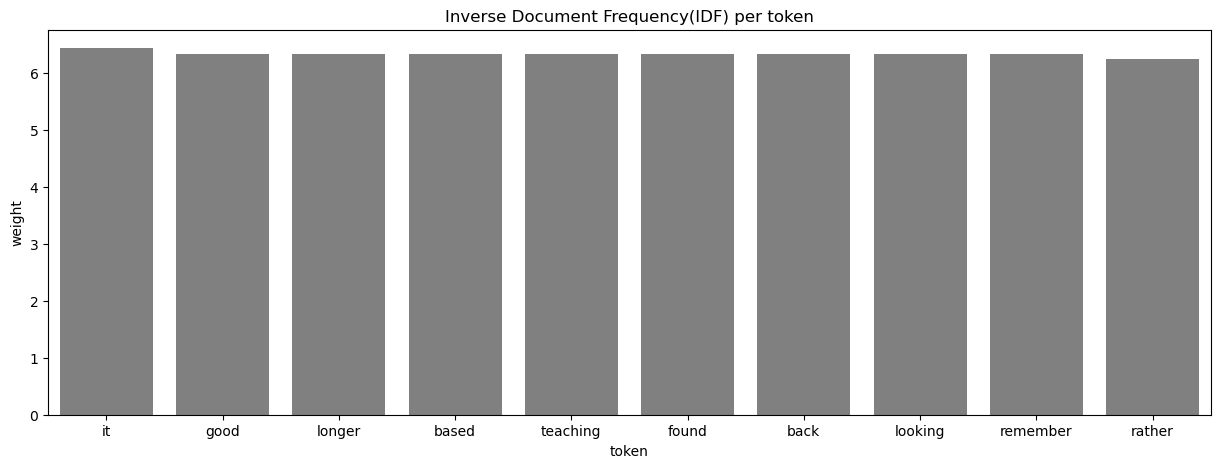

In [33]:
sns.barplot(x='token', 
            y='weight', 
            data=token_weight[0:10], 
            color="gray")            
plt.title("Inverse Document Frequency(IDF) per token")
fig = plt.gcf()
fig.set_size_inches(15,5);

Step 3: Extract outcome variable

In [35]:
# specify outcome variable
tfidf_Y = np.array(Y_train)
tfidf_Y

array([0, 0, 1, ..., 0, 1, 1])

In [36]:
tfidf_X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [37]:
tfidf_X.shape, tfidf_Y.shape

((2075, 500), (2075,))

#### Clicker Question #3

Looking at the code above and thinking about what we've done so far in this analysis, what is stored in `tfidf_Y`?

- A) predictor variable - training data
- B) outcome variable - training data
- C) predictor variable - test data
- D) outcome variable - test data
- E) validation DataFrame

# Avoiding data leakage with feature selection

NEVER do feature selection or feature transformation fitting on ALL of the data.

You don't want information about your validation and test set inside your training set.

If you fit your features on the whole dataset you have implictly told the training set information about the vocuabulary and frequency of things that aren't in the training set! BAD!

In [41]:
tfidf_train = tfidf.fit_transform(X_train)
tfidf_valid = tfidf.transform(X_valid)
tfidf_test = tfidf.transform(X_test)

In [42]:
tfidf_train.shape, tfidf_valid.shape, tfidf_test.shape

((2075, 500), (692, 500), (692, 500))

## Model

### SVM: Support Vector Machines

- simple & interpretable machine learning model
- based in linear regression
- classification task
- supervized
    - input: labeled training data
    - model determines hyperplane that best discriminates between categories

### SVM: Tuning Parameters
- **regularization** parameter
    - can determine how this line is drawn
    - can increase accuracy of prediction
    - can lead to overfitting of the data
- **kernel** parameter
    - specifies how to model & transform data
    

For more reading on SVMs using `sklearn`: https://scikit-learn.org/stable/modules/svm.html

### Model Generation
    

Step 6: Generate and train the model.

In [79]:
# uncomment to read documentation for model
SVC?

In [80]:
# function we'll use to run the model

svm_model = SVC(kernel='linear')
type(svm_model)

sklearn.svm._classes.SVC

In [81]:
# train model
svm_model = svm_model.fit(tfidf_train, Y_train)


In [82]:
svm_model.coef_.todense()

matrix([[ 0.67207611,  0.10144544, -0.33350075, -0.22254058, -0.68516746,
          0.35076476,  0.35509196, -0.0655237 , -1.13980255,  0.30191162,
          0.06643783, -0.05073229,  0.31628026, -1.10986941, -0.34299984,
          0.28069325,  0.1232623 , -0.04165024, -1.61710732, -0.96799392,
         -0.66598943,  0.6067742 , -0.33350075, -0.23311461,  0.17201411,
          0.2390977 ,  0.19062237,  1.04215154, -0.03879996,  0.07926778,
          0.99077632, -0.94054645,  1.64851649, -0.3609535 , -0.28964277,
         -0.32198959, -0.89522658, -0.17622154,  0.3184162 ,  0.53465099,
          2.13618382,  0.22743231, -0.49812202,  0.37276   , -0.65482511,
          0.90637622,  0.92465451,  0.33399231, -0.15642343,  0.01363187,
          1.09129796, -0.22409149,  0.34688295,  0.00877279, -1.16282643,
          0.7601692 ,  0.61786261, -0.69929354, -0.47395215, -0.41286439,
          0.36825804,  0.18900121,  1.09778724,  0.86053131,  0.33798966,
          0.59150546, -1.95398379, -0.

### Training Data

Step 7: Predict in the training data

In [83]:
# predict on training
df_predicted_train_Y = svm_model.predict(tfidf_train)

print(df_predicted_train_Y[0:5])
print(Y_train[0:5])

[0 0 1 1 1]
1760    0
749     0
2068    1
1989    1
1619    1
Name: most_least, dtype: int64


In [84]:
# see how many were predicted most vs. least
pd.Series(df_predicted_train_Y).value_counts()

1    1090
0     985
dtype: int64

### Testing Data

Step 8: Predict in the testing data

In [85]:
# predict on training
df_predicted_test_Y = svm_model.predict(tfidf_test)
print(df_predicted_test_Y[0:5])
print(Y_test[0:5])

[0 0 1 1 0]
665     0
410     0
2686    1
2222    1
2609    1
Name: most_least, dtype: int64


In [86]:
# see how many were predicted most vs. least
pd.Series(df_predicted_test_Y).value_counts()

1    360
0    332
dtype: int64

## Accuracy Assessment

- RMSE (continuous)
- Accuracy, Sensitivity, Specificity, AUC
    - TP, TN, FP, FN

![confusion matrix](https://miro.medium.com/max/924/1*7EYylA6XlXSGBCF77j_rOA.png)

![sensitivity recell](https://miro.medium.com/max/878/1*Ub0nZTXYT8MxLzrz0P7jPA.png)

**Accuracy** - What % were predicted correctly?  
**Sensitivity (Recall)** - Of those that were positives, what % were predicted to be positive?  ; $\frac {TP}{(TP + FN)}$  
**Specificity** - Of those that were actually negatives, what % were predicted to be negative?  $\frac {TN}{(TN + FP)}$

**Precision (Positive Predictive Value, PPV)** = $\frac {TP}{(TP + FP)}$

- probability that predicted positive truly is positive

### Training Data

Step 9: Assess accuracy in training data

In [87]:
print(classification_report(Y_train, df_predicted_train_Y))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       996
           1       0.91      0.92      0.92      1079

    accuracy                           0.91      2075
   macro avg       0.91      0.91      0.91      2075
weighted avg       0.91      0.91      0.91      2075



In [88]:
# where 'support' comes from
pd.Series(Y_train).value_counts()

1    1079
0     996
Name: most_least, dtype: int64

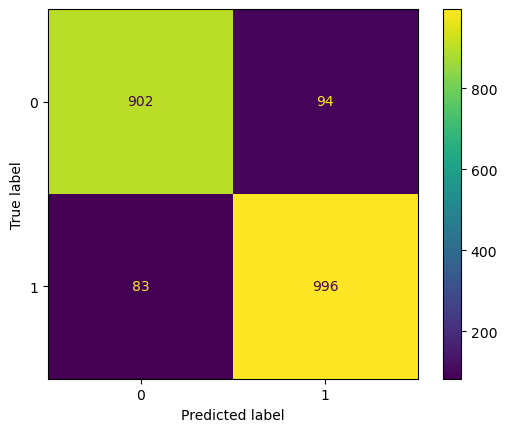

In [89]:
cm = confusion_matrix(Y_train, df_predicted_train_Y)
disp = ConfusionMatrixDisplay(cm)
disp.plot();


**support** - the number of occurrences of each class  
**precision (PPV)** - ability of the classifier not to label a positive sample as negative  
**recall (sensitivity)** - ability of the classifer to find all the positive samples


**f1-score** - weighted harmonic mean of the precision and recall; score reaches its best value at 1 and worst score at 0  
**macro average** - averaging the unweighted mean per label  
**weighted average** - averaging the support-weighted mean per label  
**micro average** - averaging the total true positives, false negatives and false positives

### Testing Data

Step 10 or 11: Assess accuracy in testing data

In [90]:
print(classification_report(Y_test, df_predicted_test_Y))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       320
           1       0.89      0.86      0.87       372

    accuracy                           0.87       692
   macro avg       0.87      0.87      0.87       692
weighted avg       0.87      0.87      0.87       692



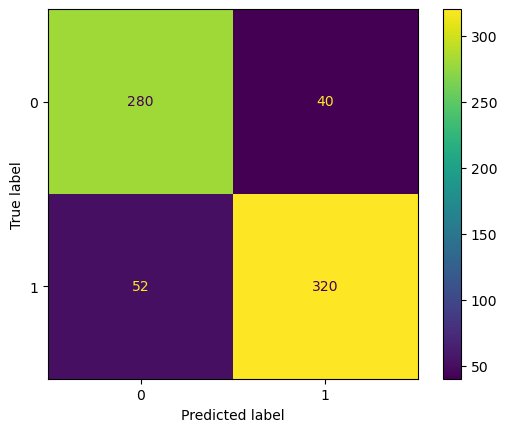

In [91]:
cm = confusion_matrix(Y_test, df_predicted_test_Y)
disp = ConfusionMatrixDisplay(cm)
disp.plot();

#### Clicker Question #4

Given this output, would you use this model to predict whether or not text was something someone liked or disliked about COGS 108?

- A) Yes
- B) No
- C) Unsure

### Doing model selection with the validation data

Actually, usually BEFORE you test, you'll want to play with hyperparameters in validation to get the best result.  Fine tuning your model.


So consider this an optional step, that usually comes before test if your model has a set of knobs and dials to twiddle.  

We only did test first above to build some intuition for you.

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       338
           1       0.83      0.82      0.82       354

    accuracy                           0.82       692
   macro avg       0.82      0.82      0.82       692
weighted avg       0.82      0.82      0.82       692



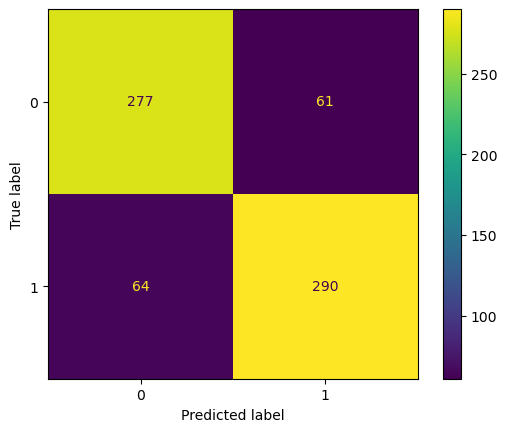

In [112]:
# play with the parameter C until it looks good
svm_model = SVC(kernel='linear', C=1E2)
svm_model.fit(tfidf_train, Y_train)
df_predicted_validation_Y = svm_model.predict(tfidf_valid)

# assess accuracy
cm = confusion_matrix(Y_valid, df_predicted_validation_Y)
disp = ConfusionMatrixDisplay(cm)
disp.plot();

print(classification_report(Y_valid, df_predicted_validation_Y))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       320
           1       0.87      0.85      0.86       372

    accuracy                           0.85       692
   macro avg       0.85      0.85      0.85       692
weighted avg       0.85      0.85      0.85       692



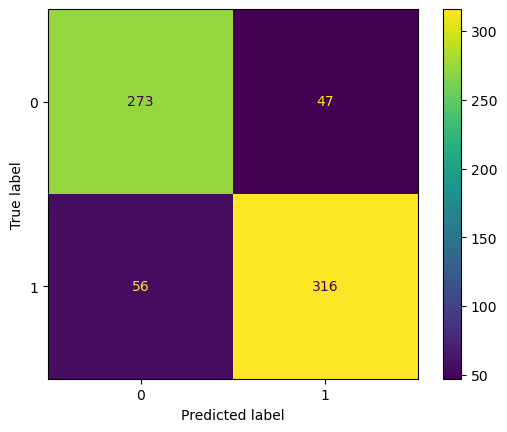

In [111]:
#assuming we left the cell above with our BEST model setting
# lets refit it with all of train+valid sets
svm_model.fit(np.concatenate([tfidf_train.todense(), tfidf_valid.todense()]), 
              np.concatenate([Y_train, Y_valid]))

# get test set predictions
df_predicted_test_Y = svm_model.predict(tfidf_test.todense())

print(classification_report(Y_test, df_predicted_test_Y))

cm = confusion_matrix(Y_test, df_predicted_test_Y)
disp = ConfusionMatrixDisplay(cm)
disp.plot();

### Summary

1. 80:20 Partition
2. Specified TF-IDF as predictor and most/least (0,1) as outcome
3. Trained SVM linear classifier
4. Built model on Training data
5. Predicted in training data and on testing data
6. Assessed overall accuracy

### Approaches For Improvement?

- Data Cleaning/Stemming
- Different Tuning Parameters?
- Cross-Validation?
- Train/Test on all data OR Train only Sp20/Fa20/Wi21 (remote quarters)
- Different Model?

To start with use sklearn the EASY way... don't try to hand code things like Train-Test split or K-Fold cross-validation... read the docs and learn how to use these wonderful functions https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

In [58]:
from sklearn.model_selection import cross_validate
results = cross_validate(svm_model, 
                         X=tfidf_validation_X, 
                         y=tfidf_validation_Y, 
                         cv=5) 
import numpy as np
np.mean(results['test_score'])

0.8884008236101579

In [59]:
from sklearn.model_selection import GridSearchCV
results = GridSearchCV(svm_model, 
                       param_grid={'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
                       cv=5)
results.fit(tfidf_validation_X,tfidf_validation_Y)
results

GridSearchCV(cv=5, estimator=SVC(kernel='linear'),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [60]:
results.param_grid


{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [61]:
results.cv_results_

{'mean_fit_time': array([0.01956401, 0.01957636, 0.01695561, 0.0152422 , 0.01232519,
        0.01478763, 0.0137537 , 0.01464758]),
 'std_fit_time': array([0.00147658, 0.00198378, 0.00194494, 0.00083107, 0.0014021 ,
        0.00115666, 0.00216205, 0.00197136]),
 'mean_score_time': array([0.00471377, 0.00468984, 0.00416455, 0.00407996, 0.00278006,
        0.00217876, 0.00230823, 0.00278711]),
 'std_score_time': array([0.00059533, 0.00088822, 0.00060906, 0.00059829, 0.00020963,
        0.00025523, 0.00038785, 0.00043398]),
 'param_C': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100},
  {'C': 1000}],
 'split0_test_score': array([0.5106383 , 0.5106383 , 0.5106383 , 0.88297872, 0.89361702,
        0.90425532, 0.90425532, 0.90425532]),
 'split

In [62]:
results.best_params_, results.best_score_

({'C': 1}, 0.8884008236101579)

## Feature engineering
One thing we didn't talk about is how you need to engineer features for NON-text kinds of inputs

In general this is a huge topic that I will try condense for you into two bullet points.

- If your data has different kinds of continuous variables, and especially if some of those variables tend to be big numbers (distance to the moon in meters) and some tend to be small numbers (the earths mass as a fraction of the earth's mass), then you need to STANDARDIZE those two variables to have roughly the same magnitude. If you don't then the ML system may think that the large magnitude variable is more predictive than the small magnitude variable.  See this link https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler
- If your data has categorical variables that do not have a natural order to them (red is not greater than blue), then you need to ONE-HOT encode those categorical variables.  Otherwise your ML system will think that red is greater than blue and that can make for some bad predictions.  See this link https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features